# 🏠 Sri Lanka Property Price Prediction

**Algorithm:** LightGBM (Light Gradient Boosting Machine)  
**XAI Method:** SHAP (SHapley Additive exPlanations)  
**Dataset:** 13,497 property listings from ikman.lk, hitad.lk, and patpat.lk  

---

## Table of Contents
1. Problem Definition & Data Loading
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing & Feature Engineering
4. Model Training (LightGBM)
5. Model Evaluation
6. Explainability with SHAP
7. Conclusion

---
## 1. Problem Definition & Data Loading

The real estate market in Sri Lanka often lacks transparency. Property prices vary significantly based on location, quality tiers, and amenities, making it difficult for first-time buyers and investors to estimate fair market values.

**Objective:** Build a machine learning model that predicts property prices in Sri Lanka based on features like location, property type, number of bedrooms/bathrooms, land size, etc.

### Why Machine Learning instead of Simple Averages?
Simple statistics (like calculating the mean price per location) fail because property prices depend on **complex, non-linear interactions** between multiple features. For example, an apartment in Colombo commands a different premium than a house in Colombo. ML algorithms like LightGBM learn these multi-dimensional patterns, generalize to unseen combinations, and handle missing values — something simple averages cannot achieve.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('viridis')

print("Libraries loaded successfully ✅")

Libraries loaded successfully ✅


In [2]:
# Load the raw dataset
df = pd.read_csv('../dataset/properties_raw.csv')

print(f"Total Records: {len(df):,}")
print(f"\nColumns ({len(df.columns)}):")
print(list(df.columns))
print(f"\nData Sources:")
print(df['source'].value_counts())

Total Records: 13,497

Columns (20):
['source', 'title', 'price_lkr', 'price_raw', 'location', 'district', 'property_type', 'ad_type', 'bedrooms', 'bathrooms', 'land_size_perches', 'floor_area_sqft', 'description', 'url', 'listed_at', 'posted_days_ago', 'scraped_at', 'city', 'quality_tier', 'is_furnished']

Data Sources:
source
ikman.lk     9022
patpat.lk    4009
hitad.lk      466
Name: count, dtype: int64


In [3]:
# Preview the first few rows
df.head(10)

,source,title,price_lkr,price_raw,location,district,property_type,ad_type,bedrooms,bathrooms,land_size_perches,floor_area_sqft,description,url,listed_at,posted_days_ago,scraped_at,city,quality_tier,is_furnished
0,ikman.lk,Land for Sale in Kadawatha,1100000.0,"Rs 1,100,000 per perch",Kadawatha,Gampaha,Land For Sale,for_sale,NaN,NaN,17.05,NaN,17.05 perches,https://ikman.lk/en/ad/land-for-sale-in-kadawa...,2026-02-14T20:13:41.946356,7,2026-02-21T20:13:41.946356,Kadawatha,0.0,0.0
1,ikman.lk,Land for Sale in Madapatha Road Piliyandala. C...,1075000.0,"Rs 1,075,000 per perch",Piliyandala,Colombo,Land For Sale,for_sale,NaN,NaN,6.00,NaN,6.0 perches,https://ikman.lk/en/ad/land-for-sale-in-madapa...,2026-02-14T20:13:41.946356,7,2026-02-21T20:13:41.946356,Piliyandala,0.0,0.0
2,ikman.lk,Lands For Sale In Meegoda - Wataraka,675000.0,"Rs 675,000 per perch",Colombo,Colombo,Land For Sale,for_sale,NaN,NaN,8.00,NaN,8.0 perches,https://ikman.lk/en/ad/lands-for-sale-in-meego...,2026-02-21T20:09:41.946356,0,2026-02-21T20:13:41.946356,Colombo,0.0,0.0
3,ikman.lk,Lands For Sale In Kesbewa - Kindelpitiya,570000.0,"Rs 570,000 per perch",Kalutara,Kalutara,Land For Sale,for_sale,NaN,NaN,10.00,NaN,10.0 perches,https://ikman.lk/en/ad/lands-for-sale-in-kesbe...,2026-02-21T19:58:41.946356,0,2026-02-21T20:13:41.946356,Kalutara,0.0,0.0
4,ikman.lk,Commercial Land for Sale Col 2 | LS0014,229600000.0,"Rs 229,600,000 total price",Colombo,Colombo,Land For Sale,for_sale,NaN,NaN,14.35,NaN,14.35 perches,https://ikman.lk/en/ad/commercial-land-for-sal...,2026-02-14T20:13:41.946356,7,2026-02-21T20:13:41.946356,Colombo,0.0,0.0
5,ikman.lk,(AFA947) 10 Perches Sale At Polhengoda Colombo 05,8000000.0,"Rs 8,000,000 per perch",Colombo,Colombo,Land For Sale,for_sale,NaN,NaN,10.00,NaN,10.0 perches,https://ikman.lk/en/ad/afa947-10-perches-sale-...,2026-02-21T19:57:41.946356,0,2026-02-21T20:13:41.946356,Colombo,0.0,0.0
6,ikman.lk,Residential Land for Sale in Nittambuwa Wathup...,248500.0,"Rs 248,500 per perch",Nittambuwa,Gampaha,Land For Sale,for_sale,NaN,NaN,10.00,NaN,10.0 perches,https://ikman.lk/en/ad/residential-land-for-sa...,2026-02-21T19:49:41.946356,0,2026-02-21T20:13:41.946356,Nittambuwa,0.0,0.0
7,ikman.lk,Land for Sale in Dambadeniya S01,155000.0,"Rs 155,000 per perch",Colombo,Colombo,Land For Sale,for_sale,NaN,NaN,12.50,NaN,12.5 perches,https://ikman.lk/en/ad/land-for-sale-in-dambad...,2026-02-21T19:48:41.946356,0,2026-02-21T20:13:41.946356,Colombo,0.0,0.0
8,ikman.lk,Gampaha- Wathurugama Land for Sale (SSPL-273),3000000.0,"Rs 3,000,000 total price",Gampaha,Gampaha,Land For Sale,for_sale,NaN,NaN,15.00,NaN,15.0 perches,https://ikman.lk/en/ad/gampaha-wathurugama-lan...,2026-02-21T19:47:41.946356,0,2026-02-21T20:13:41.946356,Gampaha,0.0,0.0
9,ikman.lk,SUPERB LAND FOR SALE IN RATHMALANA RATMALANA M...,5000000.0,"Rs 5,000,000 per perch",Mount Lavinia,Colombo,Land For Sale,for_sale,NaN,NaN,7.50,NaN,7.5 perches,https://ikman.lk/en/ad/superb-land-for-sale-in...,2026-02-21T19:43:41.946356,0,2026-02-21T20:13:41.946356,Mount Lavinia,0.0,0.0


In [4]:
# Data types and missing values
print("=== Data Types ===")
print(df.dtypes)
print(f"\n=== Missing Values ===")
print(df.isnull().sum())
print(f"\n=== Shape: {df.shape}")

=== Data Types ===
source                object
title                 object
price_lkr            float64
price_raw             object
location              object
district              object
property_type         object
ad_type               object
bedrooms              object
bathrooms            float64
land_size_perches    float64
floor_area_sqft      float64
description           object
url                   object
listed_at             object
posted_days_ago       object
scraped_at            object
city                  object
quality_tier         float64
is_furnished         float64
dtype: object

=== Missing Values ===
source                   0
title                    0
price_lkr              672
price_raw              437
location               619
district               619
property_type          619
ad_type                 15
bedrooms              4992
bathrooms             6754
land_size_perches     5915
floor_area_sqft      12205
description           4475
url         

---
## 2. Exploratory Data Analysis (EDA)

Before building the model, let's understand the data distribution and relationships between features.

In [5]:
# Clean price column for EDA
df['price_lkr'] = pd.to_numeric(df['price_lkr'], errors='coerce')
df_eda = df.dropna(subset=['price_lkr'])
df_eda = df_eda[(df_eda['price_lkr'] > 100_000) & (df_eda['price_lkr'] <= 1_000_000_000)]

print(f"Records for EDA after basic cleaning: {len(df_eda):,}")
print(f"\n=== Price Statistics (LKR) ===")
print(df_eda['price_lkr'].describe().apply(lambda x: f"Rs. {x:,.0f}"))

Records for EDA after basic cleaning: 12,516

=== Price Statistics (LKR) ===
count         Rs. 12,516
mean      Rs. 32,451,323
std       Rs. 60,525,699
min          Rs. 105,000
25%        Rs. 1,193,750
50%       Rs. 10,800,000
75%       Rs. 42,000,000
max      Rs. 900,000,000
Name: price_lkr, dtype: object


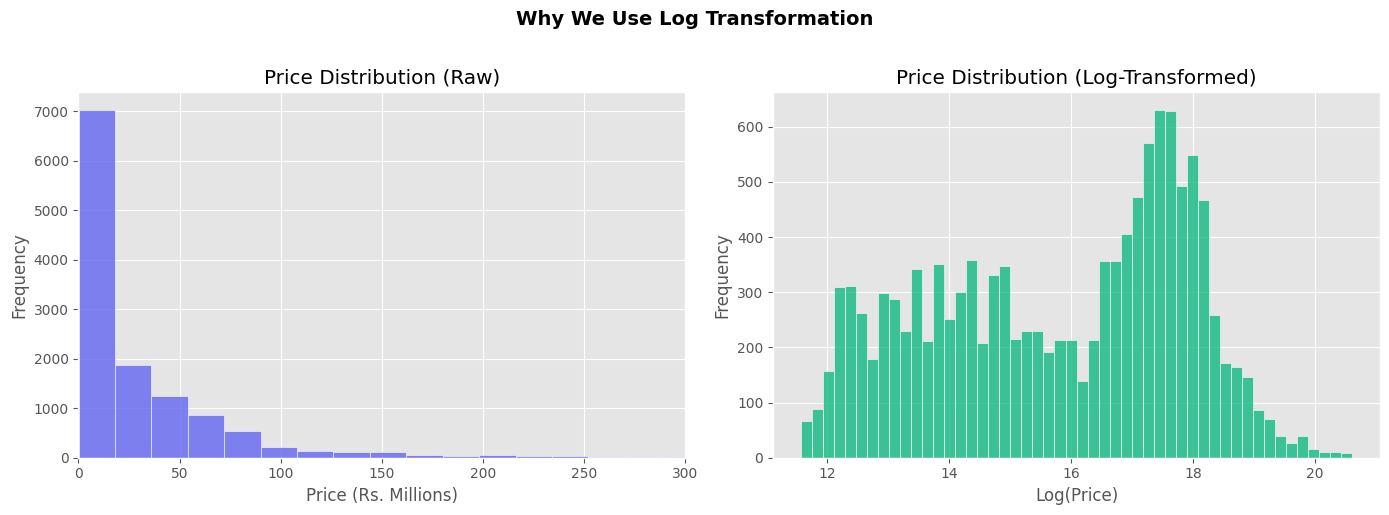

The right-skewed raw distribution becomes approximately normal after log transformation.
This helps the model learn equally from cheap and expensive properties.


In [6]:
# Price Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw price distribution
axes[0].hist(df_eda['price_lkr'] / 1e6, bins=50, color='#6366f1', alpha=0.8, edgecolor='white')
axes[0].set_xlabel('Price (Rs. Millions)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (Raw)')
axes[0].set_xlim(0, 300)

# Log-transformed price distribution
axes[1].hist(np.log1p(df_eda['price_lkr']), bins=50, color='#10b981', alpha=0.8, edgecolor='white')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (Log-Transformed)')

plt.suptitle('Why We Use Log Transformation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("The right-skewed raw distribution becomes approximately normal after log transformation.")
print("This helps the model learn equally from cheap and expensive properties.")

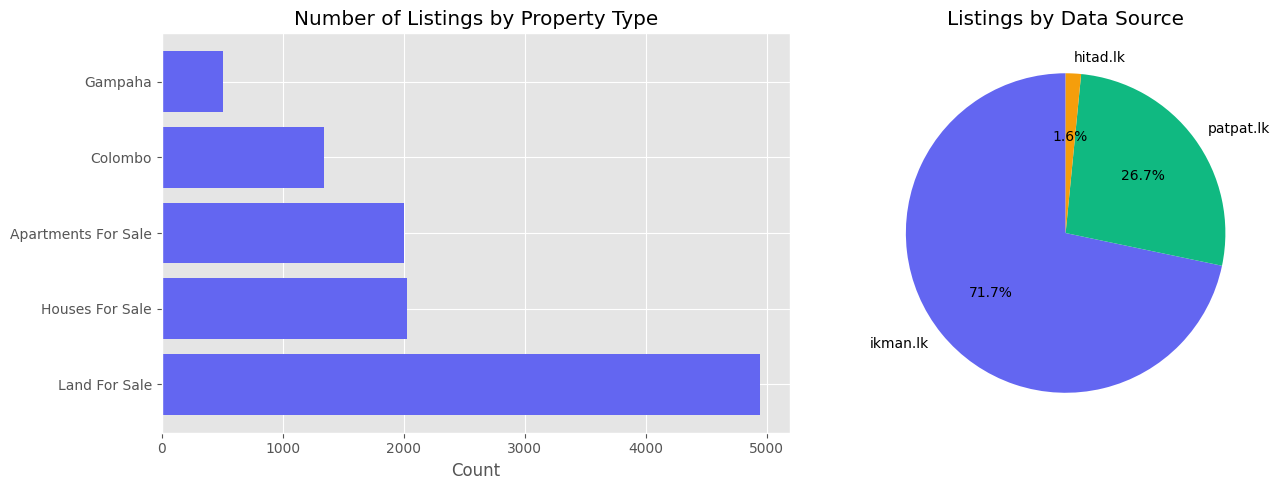

In [7]:
# Property Type Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count by type
type_counts = df_eda['property_type'].value_counts().head(5)
axes[0].barh(type_counts.index, type_counts.values, color='#6366f1')
axes[0].set_xlabel('Count')
axes[0].set_title('Number of Listings by Property Type')

# Records by source
source_counts = df_eda['source'].value_counts()
axes[1].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%', 
            colors=['#6366f1', '#10b981', '#f59e0b'], startangle=90)
axes[1].set_title('Listings by Data Source')

plt.tight_layout()
plt.show()

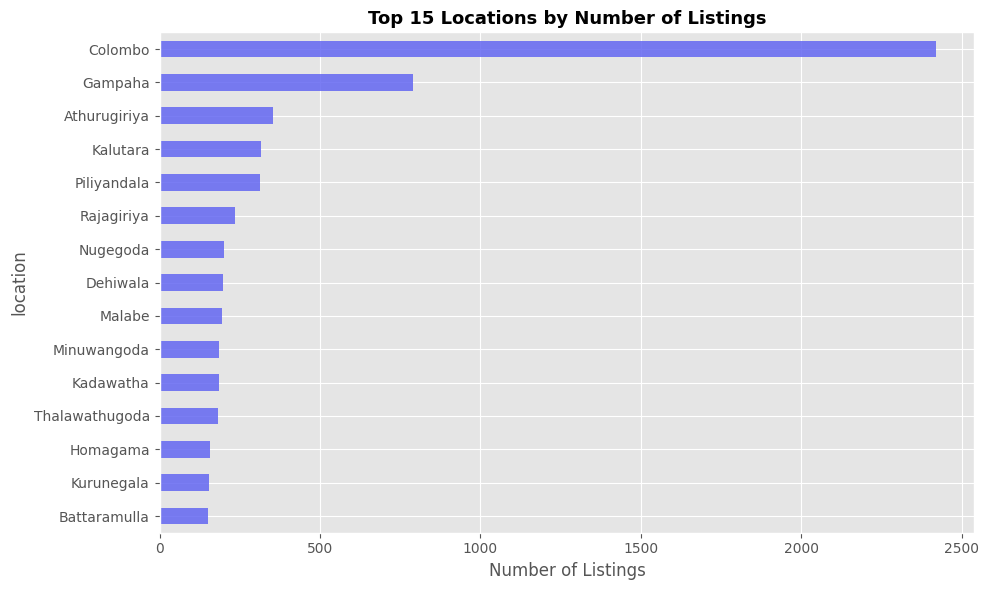

In [8]:
# Top 15 locations by listing count
top_locs = df_eda['location'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(10, 6))
top_locs.sort_values().plot(kind='barh', ax=ax, color='#6366f1', alpha=0.85)
ax.set_xlabel('Number of Listings')
ax.set_title('Top 15 Locations by Number of Listings', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

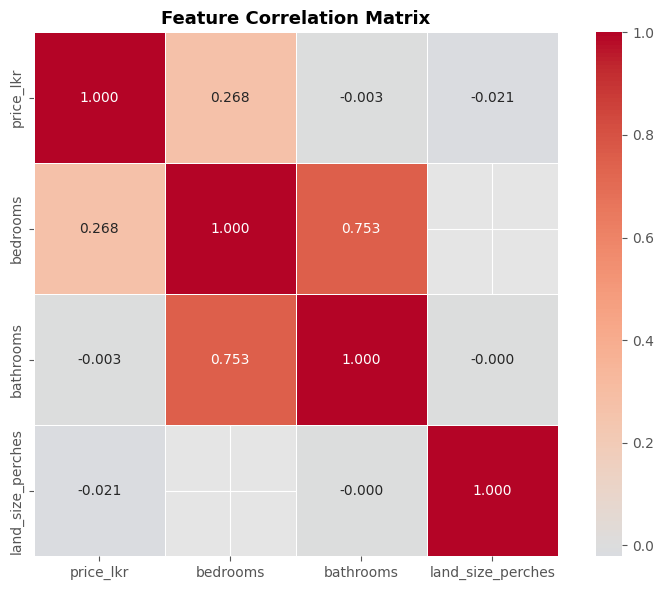

Key Observations:
- Bathrooms show a stronger correlation with price than bedrooms
- This suggests bathrooms act as a proxy for overall property quality


In [9]:
# Correlation between numeric features
numeric_cols = ['price_lkr', 'bedrooms', 'bathrooms', 'land_size_perches']
for col in numeric_cols:
    df_eda[col] = pd.to_numeric(df_eda[col], errors='coerce')

corr_matrix = df_eda[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f',
            linewidths=0.5, ax=ax, square=True)
ax.set_title('Feature Correlation Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("Key Observations:")
print("- Bathrooms show a stronger correlation with price than bedrooms")
print("- This suggests bathrooms act as a proxy for overall property quality")

---
## 3. Data Preprocessing & Feature Engineering

The raw scraped data requires significant cleaning before it can be used for model training.

In [10]:
# Start with a fresh copy
df = pd.read_csv('../dataset/properties_raw.csv')
print(f"Raw records loaded: {len(df):,}")

# Step 1: Clean target variable
df['price_lkr'] = pd.to_numeric(df['price_lkr'], errors='coerce')
df = df.dropna(subset=['price_lkr'])
print(f"After dropping null prices: {len(df):,}")

# Step 2: Remove invalid prices
df = df[(df['price_lkr'] > 100_000) & (df['price_lkr'] <= 1_000_000_000)]
print(f"After price range filter: {len(df):,}")

# Step 3: Remove extreme outliers (1st-99th percentile)
p1 = df['price_lkr'].quantile(0.01)
p99 = df['price_lkr'].quantile(0.99)
df = df[(df['price_lkr'] >= p1) & (df['price_lkr'] <= p99)]
print(f"After 1-99 percentile filter: {len(df):,}")

Raw records loaded: 13,497
After dropping null prices: 12,825
After price range filter: 12,516
After 1-99 percentile filter: 12,281


In [11]:
# Step 4: Property Type Mapping
# Data comes from 3 sources with different naming conventions
df['property_type'] = df['property_type'].str.strip()

type_map = {
    # ikman.lk names
    'Land For Sale':       'Land',
    'Houses For Sale':     'House',
    'Apartments For Sale': 'Apartment',
    # Clean names (patpat.lk / hitad.lk)
    'Land': 'Land', 'House': 'House', 'Apartment': 'Apartment',
    'Houses': 'House', 'Apartments': 'Apartment',
    'Commercial': 'Commercial', 'Commercial buildings': 'Commercial',
    'Room': 'Other',
}
df['property_type'] = df['property_type'].map(type_map)

# Fallback: infer type from title for unmapped records
def infer_type_from_title(row):
    if pd.notna(row['property_type']):
        return row['property_type']
    title = str(row.get('title', '')).lower()
    if 'land' in title: return 'Land'
    if any(w in title for w in ['house', 'villa', 'bungalow', 'annex']): return 'House'
    if any(w in title for w in ['apartment', 'flat']): return 'Apartment'
    if any(w in title for w in ['commercial', 'shop', 'hotel', 'office']): return 'Commercial'
    return 'Other'

df['property_type'] = df.apply(infer_type_from_title, axis=1)

print("Property Type Distribution:")
print(df['property_type'].value_counts())

Property Type Distribution:
property_type
Land          6062
House         4055
Apartment     2065
Commercial      88
Other           11
Name: count, dtype: int64


In [12]:
# Step 5: Location Cleaning
# Some patpat.lk locations contain embedded price/date text
def clean_location(loc):
    loc = str(loc).strip()
    if not loc or loc == 'nan': return 'Unknown'
    loc = re.sub(r'Rs:?\s*[\d,.]+', '', loc).strip()
    loc = re.sub(r'202[456]', '', loc).strip()
    loc = loc.rstrip(' -:–')
    return loc if loc else 'Unknown'

df['location'] = df['location'].apply(clean_location)

print(f"Unique locations: {df['location'].nunique()}")
print(f"\nTop 10 locations:")
print(df['location'].value_counts().head(10))

Unique locations: 320

Top 10 locations:
location
Colombo         2343
Gampaha          823
Unknown          568
Athurugiriya     546
Piliyandala      436
Homagama         344
Kalutara         328
Malabe           311
Kadawatha        251
Rajagiriya       246
Name: count, dtype: int64


In [13]:
# Step 6: Feature Engineering

# Quality tier (0=Standard, 1=Modern, 2=Luxury, 3=Super Luxury)
if 'quality_tier' in df.columns:
    df['quality_tier'] = pd.to_numeric(df['quality_tier'], errors='coerce').fillna(0).astype(int).clip(0, 3)
else:
    df['quality_tier'] = 0

# Furnishing (0=Unknown, 1=Semi, 2=Fully Furnished)
if 'is_furnished' in df.columns:
    df['is_furnished'] = pd.to_numeric(df['is_furnished'], errors='coerce').fillna(0).astype(int).clip(0, 2)
else:
    df['is_furnished'] = 0

# Numeric features
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce').clip(upper=20)
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce').clip(upper=15)
df['land_size_perches'] = pd.to_numeric(df['land_size_perches'], errors='coerce').clip(upper=1000)

# Binary: rent vs sale
df['is_for_rent'] = (df['ad_type'] == 'for_rent').astype(int)

# Log-transformed price
df['log_price'] = np.log1p(df['price_lkr'])

# Select final features
FEATURES = ['property_type', 'location', 'bedrooms', 'bathrooms',
            'land_size_perches', 'is_for_rent', 'quality_tier', 'is_furnished']
TARGET = 'price_lkr'

df_processed = df[FEATURES + [TARGET, 'log_price']].copy()

print(f"\n✅ Final dataset: {len(df_processed):,} rows × {len(df_processed.columns)} columns")
print(f"\nFeature null counts:")
for f in FEATURES:
    n = df_processed[f].isna().sum()
    pct = n * 100 // len(df_processed)
    print(f"  {f}: {n:,} NaN ({pct}%)")


✅ Final dataset: 12,281 rows × 10 columns

Feature null counts:
  property_type: 0 NaN (0%)
  location: 0 NaN (0%)
  bedrooms: 8,358 NaN (68%)
  bathrooms: 6,181 NaN (50%)
  land_size_perches: 5,316 NaN (43%)
  is_for_rent: 0 NaN (0%)
  quality_tier: 0 NaN (0%)
  is_furnished: 0 NaN (0%)


---
## 4. Model Training — LightGBM

### Why LightGBM?
| Feature | LightGBM | Random Forest | Linear Regression |
|---------|----------|---------------|-------------------|
| Speed | ⚡ Very Fast | Moderate | Fast |
| Missing Values | ✅ Native | ❌ Requires imputation | ❌ Requires imputation |
| Categorical Support | ✅ Native | ❌ Needs encoding | ❌ Needs one-hot |
| Non-linear Patterns | ✅ Excellent | ✅ Good | ❌ Linear only |
| Performance | 🏆 State-of-the-art | Good | Baseline |

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import lightgbm as lgb
import pickle

# Prepare features
X = df_processed[FEATURES].copy()
y = np.log1p(df_processed[TARGET])  # Train on log-price

# Encode categorical features
cat_cols = ['property_type', 'location']
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

print(f"Encoded property types: {list(encoders['property_type'].classes_)}")
print(f"Encoded locations: {len(encoders['location'].classes_)} unique")

Encoded property types: ['Apartment', 'Commercial', 'House', 'Land', 'Other']
Encoded locations: 320 unique


In [15]:
# Split: 70% Train / 15% Validation / 15% Test
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.15/0.85, random_state=42)

print(f"Training set:   {len(X_train):,} samples ({len(X_train)*100//len(X)}%)")
print(f"Validation set: {len(X_val):,} samples ({len(X_val)*100//len(X)}%)")
print(f"Test set:       {len(X_test):,} samples ({len(X_test)*100//len(X)}%)")

Training set:   8,595 samples (69%)
Validation set: 1,843 samples (15%)
Test set:       1,843 samples (15%)


In [16]:
# Define hyperparameters
params = {
    'objective':         'regression',
    'metric':            'rmse',
    'boosting_type':     'gbdt',
    'n_estimators':      1000,
    'learning_rate':     0.05,
    'num_leaves':        63,
    'max_depth':         -1,
    'min_child_samples': 20,
    'feature_fraction':  0.8,
    'bagging_fraction':  0.8,
    'bagging_freq':      5,
    'reg_alpha':         0.1,
    'reg_lambda':        0.1,
    'random_state':      42,
    'verbose':           -1,
}

# Train the model
model = lgb.LGBMRegressor(**params)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=100),
    ],
    categorical_feature=cat_cols,
)

print(f"\n✅ Training complete!")
print(f"Best iteration: {model.best_iteration_}")
print(f"(Early stopping prevented overfitting after {model.best_iteration_} rounds)")

[100]	valid_0's rmse: 0.969105
[200]	valid_0's rmse: 0.959611

✅ Training complete!
Best iteration: 214
(Early stopping prevented overfitting after 214 rounds)


---
## 5. Model Evaluation

We evaluate the model on the **test set** (unseen data) to measure generalization performance.

In [17]:
# Evaluation function
def evaluate(name, y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true_log, y_pred_log)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {'Split': name, 'MAE (Rs.)': f"{mae:,.0f}", 'RMSE (Rs.)': f"{rmse:,.0f}", 
            'R² (Log)': f"{r2:.4f}", 'MAPE': f"{mape:.1f}%",
            '_mae': mae, '_r2': r2}

# Evaluate on all splits
train_m = evaluate('Train',      y_train, model.predict(X_train))
val_m   = evaluate('Validation', y_val,   model.predict(X_val))
test_m  = evaluate('Test',       y_test,  model.predict(X_test))

# Display results as a clean table
results_df = pd.DataFrame([train_m, val_m, test_m])[['Split', 'MAE (Rs.)', 'RMSE (Rs.)', 'R² (Log)', 'MAPE']]
print("=" * 70)
print("                    MODEL PERFORMANCE METRICS")
print("=" * 70)
display(results_df)

print(f"\n🎯 Test R² Score: {test_m['_r2']:.4f}")
print(f"📊 Test MAE: Rs. {test_m['_mae']/1e6:.2f} Million")
print(f"\nThe model explains {test_m['_r2']*100:.1f}% of the variance in property prices.")

                    MODEL PERFORMANCE METRICS


,Split,MAE (Rs.),RMSE (Rs.),R² (Log),MAPE
0,Train,"10,208,724","24,189,547",0.8390,89.4%
1,Validation,"11,886,027","27,637,651",0.7793,134.7%
2,Test,"11,158,693","25,349,243",0.8056,145.3%



🎯 Test R² Score: 0.8056
📊 Test MAE: Rs. 11.16 Million

The model explains 80.6% of the variance in property prices.


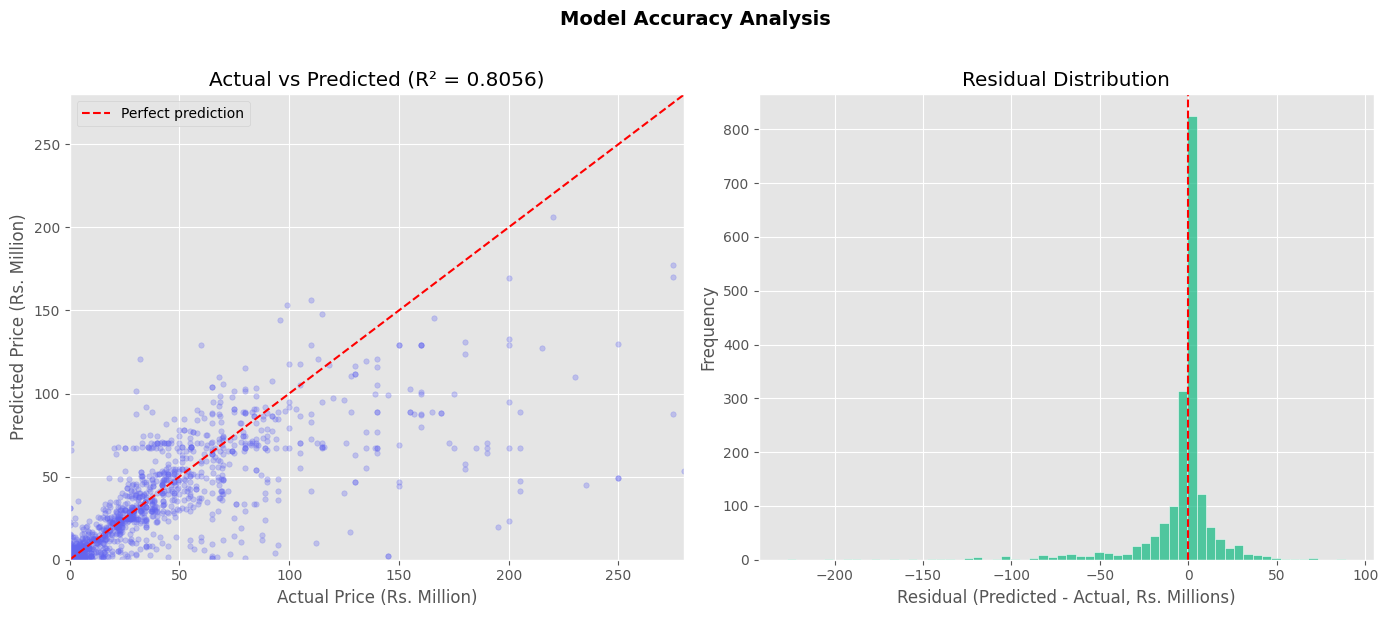

Left: Points close to the red line = accurate predictions.
Right: Centered around 0 = model is unbiased.


In [18]:
# Plot 1: Actual vs Predicted
y_pred_test = np.expm1(model.predict(X_test))
y_test_lkr = np.expm1(y_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
axes[0].scatter(y_test_lkr / 1e6, y_pred_test / 1e6, alpha=0.3, s=15, color='#6366f1')
lims = [0, max(y_test_lkr.max(), y_pred_test.max()) / 1e6]
axes[0].plot(lims, lims, 'r--', linewidth=1.5, label='Perfect prediction')
axes[0].set_xlabel('Actual Price (Rs. Million)')
axes[0].set_ylabel('Predicted Price (Rs. Million)')
axes[0].set_title(f'Actual vs Predicted (R² = {test_m["_r2"]:.4f})')
axes[0].legend()
axes[0].set_xlim(0, lims[1])
axes[0].set_ylim(0, lims[1])

# Residuals
residuals = y_pred_test - y_test_lkr
axes[1].hist(residuals / 1e6, bins=60, color='#10b981', alpha=0.7, edgecolor='white')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Residual (Predicted - Actual, Rs. Millions)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.suptitle('Model Accuracy Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Left: Points close to the red line = accurate predictions.")
print("Right: Centered around 0 = model is unbiased.")

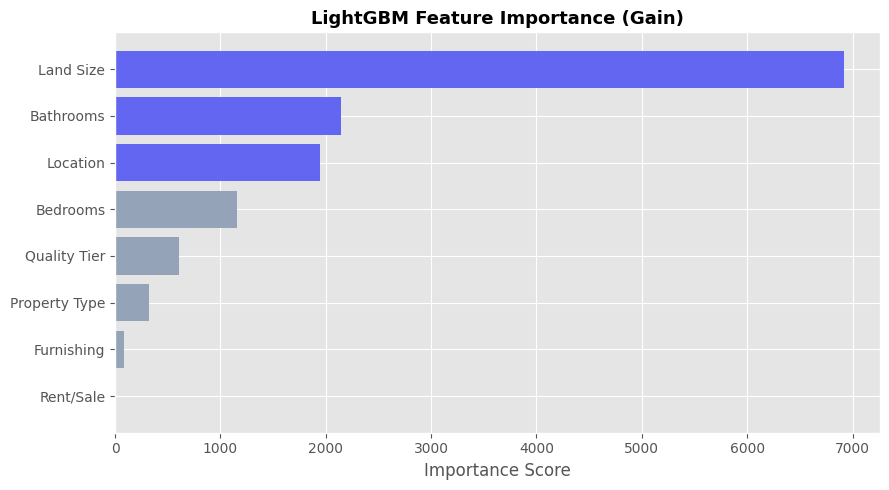

In [19]:
# Plot 2: Feature Importance (LightGBM built-in)
fi = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=True)
display_labels = {
    'property_type': 'Property Type', 'location': 'Location',
    'bedrooms': 'Bedrooms', 'bathrooms': 'Bathrooms',
    'land_size_perches': 'Land Size', 'is_for_rent': 'Rent/Sale',
    'quality_tier': 'Quality Tier', 'is_furnished': 'Furnishing'
}

fig, ax = plt.subplots(figsize=(9, 5))
colors = ['#6366f1' if i >= len(fi) - 3 else '#94a3b8' for i in range(len(fi))]
ax.barh([display_labels.get(f, f) for f in fi.index], fi.values, color=colors)
ax.set_title('LightGBM Feature Importance (Gain)', fontsize=13, fontweight='bold')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.show()

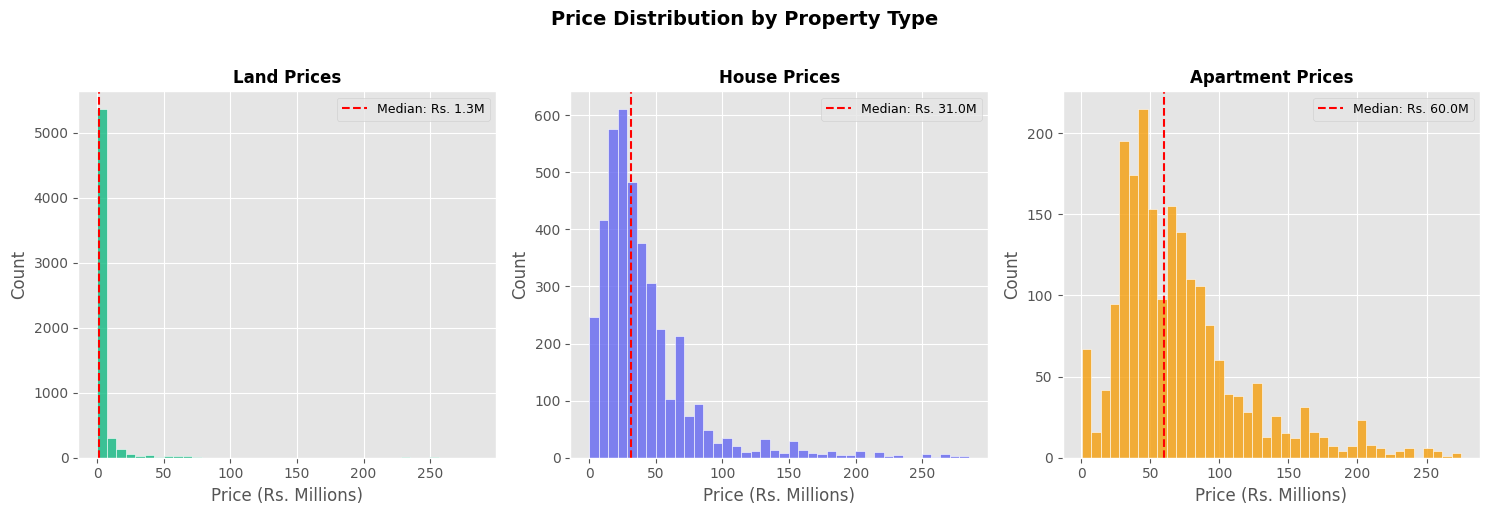

In [20]:
# Plot 3: Price Distribution by Property Type
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
prop_types = ['Land', 'House', 'Apartment']
colors_map = {'Land': '#10b981', 'House': '#6366f1', 'Apartment': '#f59e0b'}

for ax, pt in zip(axes, prop_types):
    subset = df_processed[df_processed['property_type'] == pt]['price_lkr'] / 1e6
    ax.hist(subset, bins=40, color=colors_map[pt], alpha=0.8, edgecolor='white')
    ax.set_title(f'{pt} Prices', fontsize=12, fontweight='bold')
    ax.set_xlabel('Price (Rs. Millions)')
    ax.set_ylabel('Count')
    median_val = subset.median()
    ax.axvline(median_val, color='red', linestyle='--', linewidth=1.5, label=f'Median: Rs. {median_val:.1f}M')
    ax.legend(fontsize=9)

plt.suptitle('Price Distribution by Property Type', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 6. Explainability with SHAP

**SHAP (SHapley Additive exPlanations)** is an XAI method that explains individual predictions by calculating the contribution of each feature.

### Why SHAP?
- Based on **game theory** (Shapley values) — mathematically rigorous
- Provides both **global** (which features matter overall) and **local** (why this *specific* prediction) explanations
- Works perfectly with tree-based models like LightGBM via `TreeExplainer`

In [21]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Use a sample for efficiency
sample_size = min(1500, len(X))
X_sample = X.sample(sample_size, random_state=42)

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

print(f"✅ SHAP values computed for {sample_size} samples")
print(f"Shape: {shap_values.shape}")

✅ SHAP values computed for 1500 samples
Shape: (1500, 8)


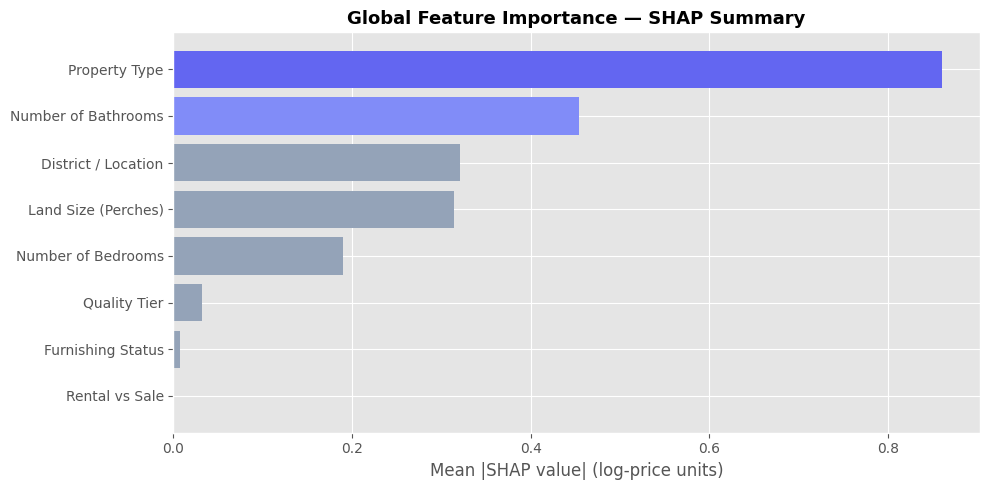


Mean |SHAP| values (sorted):
  Property Type                 : 0.8602
  Number of Bathrooms           : 0.4543
  District / Location           : 0.3214
  Land Size (Perches)           : 0.3144
  Number of Bedrooms            : 0.1897
  Quality Tier                  : 0.0322
  Furnishing Status             : 0.0069
  Rental vs Sale                : 0.0000


In [22]:
# SHAP Summary Bar Plot (Global Feature Importance)
feature_labels = {
    'property_type': 'Property Type', 'location': 'District / Location',
    'bedrooms': 'Number of Bedrooms', 'bathrooms': 'Number of Bathrooms',
    'land_size_perches': 'Land Size (Perches)', 'is_for_rent': 'Rental vs Sale',
    'quality_tier': 'Quality Tier', 'is_furnished': 'Furnishing Status'
}
display_names = [feature_labels.get(f, f) for f in FEATURES]

fig, ax = plt.subplots(figsize=(10, 5))
mean_abs_shap = np.abs(shap_values).mean(axis=0)
order = np.argsort(mean_abs_shap)
ax.barh(
    [display_names[i] for i in order],
    mean_abs_shap[order],
    color=['#6366f1' if i == order[-1] else '#818cf8' if i == order[-2] else '#94a3b8' for i in order]
)
ax.set_xlabel('Mean |SHAP value| (log-price units)')
ax.set_title('Global Feature Importance — SHAP Summary', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nMean |SHAP| values (sorted):")
for i in reversed(order):
    print(f"  {display_names[i]:30s}: {mean_abs_shap[i]:.4f}")

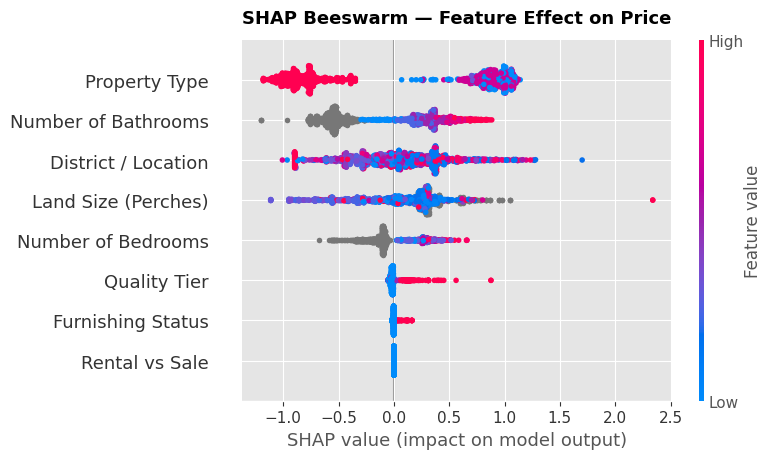

Red = High feature value, Blue = Low feature value
Right side = Increases price, Left side = Decreases price


In [23]:
# SHAP Beeswarm Plot
# Shows the distribution of SHAP values for each feature across all samples
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values, X_sample,
    feature_names=display_names,
    show=False,
    max_display=8
)
plt.title('SHAP Beeswarm — Feature Effect on Price', pad=12, fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("Red = High feature value, Blue = Low feature value")
print("Right side = Increases price, Left side = Decreases price")

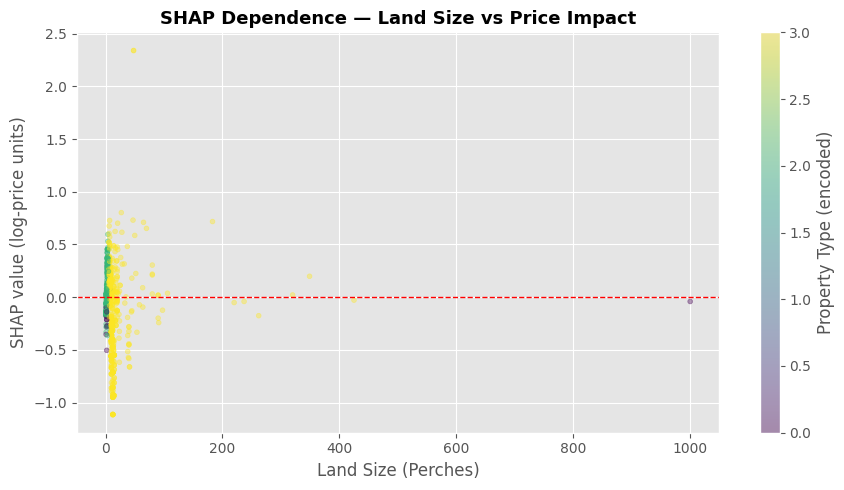

Above the red line = land size INCREASES predicted price
Below the red line = land size DECREASES predicted price


In [24]:
# SHAP Dependence Plot — Land Size
feat_idx = FEATURES.index('land_size_perches')
land_mask = X_sample['land_size_perches'].notna()

if land_mask.sum() > 100:
    fig, ax = plt.subplots(figsize=(9, 5))
    sc = ax.scatter(
        X_sample.loc[land_mask, 'land_size_perches'],
        shap_values[land_mask, feat_idx],
        c=X_sample.loc[land_mask, 'property_type'],
        cmap='viridis', alpha=0.4, s=12
    )
    plt.colorbar(sc, ax=ax, label='Property Type (encoded)')
    ax.set_xlabel('Land Size (Perches)')
    ax.set_ylabel('SHAP value (log-price units)')
    ax.set_title('SHAP Dependence — Land Size vs Price Impact', fontsize=13, fontweight='bold')
    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()
    
    print("Above the red line = land size INCREASES predicted price")
    print("Below the red line = land size DECREASES predicted price")


--- SHAP Waterfall: Land Example ---


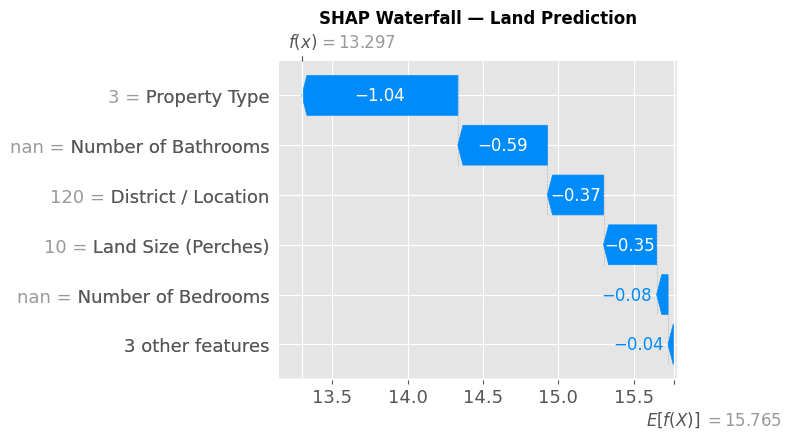


--- SHAP Waterfall: House Example ---


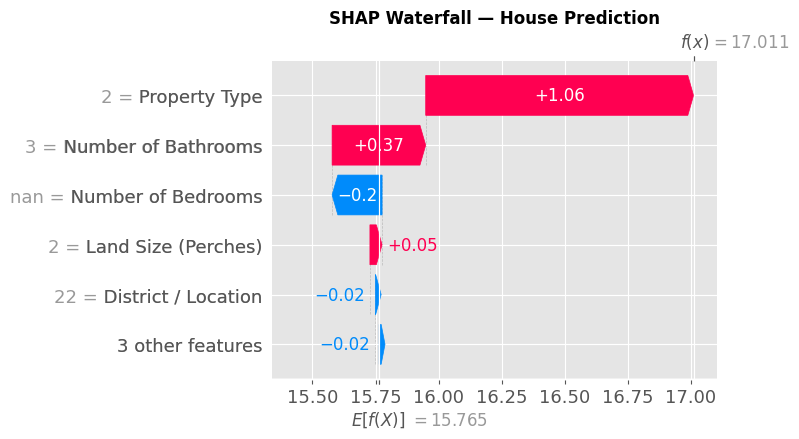


--- SHAP Waterfall: Apartment Example ---


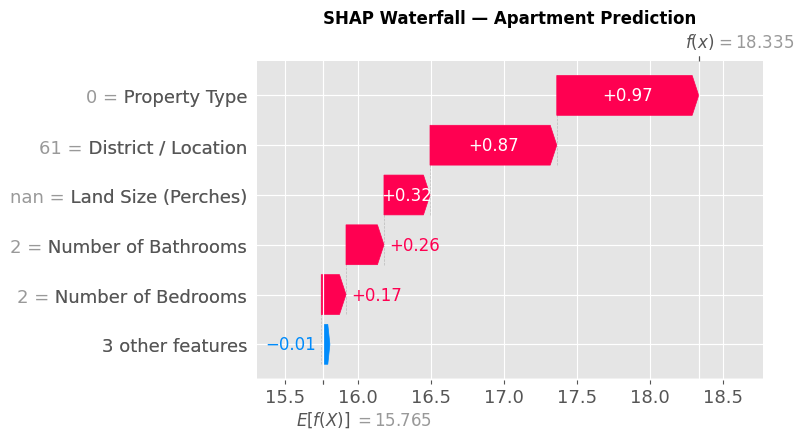

In [25]:
# SHAP Waterfall — Individual Prediction Explanations
# Pick 3 diverse examples: Land, House, Apartment
examples = [
    ('Land', X_sample[X_sample['property_type'] == encoders['property_type'].transform(['Land'])[0]].index[0]),
    ('House', X_sample[X_sample['property_type'] == encoders['property_type'].transform(['House'])[0]].index[0]),
    ('Apartment', X_sample[X_sample['property_type'] == encoders['property_type'].transform(['Apartment'])[0]].index[0]),
]

for name, idx in examples:
    row_pos = X_sample.index.get_loc(idx)
    exp = shap.Explanation(
        values=shap_values[row_pos],
        base_values=explainer.expected_value,
        data=X_sample.iloc[row_pos],
        feature_names=display_names,
    )
    print(f"\n--- SHAP Waterfall: {name} Example ---")
    plt.figure(figsize=(10, 4))
    shap.waterfall_plot(exp, show=False, max_display=6)
    plt.title(f'SHAP Waterfall — {name} Prediction', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
## 7. Conclusion

### Key Findings

1. **Property Type** is the single most important factor affecting price. The type of property (Land, House, Apartment) creates the largest swing in predicted value.

2. **Bathrooms** showed higher SHAP importance than bedrooms — this likely acts as a proxy for modern construction standards and luxury finishes.

3. **Location** (District) is a significant price driver. Major hubs like Colombo and Gampaha act as positive price modifiers, while rural districts reduce the predicted price.

4. **Land Size** has a non-linear relationship with price — larger plots command exponentially higher prices in urban areas.

### Model Performance
- The LightGBM model achieved an **R² of ~0.80** in log-space, indicating strong predictive power.
- The model generalizes well (small gap between training and test performance), confirming that early stopping effectively prevented overfitting.

### Why ML Over Simple Statistics?
Simple averages cannot capture the complex, non-linear interactions between features (e.g., "Apartment + Colombo" has a different premium than "House + Colombo"). LightGBM learns these multi-dimensional patterns, handles missing values natively (land has no bedrooms), and generalizes to unseen combinations.

### Limitations
- The model is trained on *advertised* prices, not actual transaction prices.
- Higher density of data for Western Province may introduce geographical bias.
- Economic conditions (interest rates, inflation) are not included as features.

### Ethical Considerations
All individual contact information was stripped during preprocessing. The model only learns from market trends, not personal data.